# Questions
1. What tables and features differentiate blood-transfusion-related and non-blood-transfusion-related admittances?
2. How many hospital admittances in MIMIC-III are for blood transfusions?
3. Break down these stats by race, by gender, by other demographics
4. How common is it for a blood transfusion to be cut short?
5. What's the average/most extreme body temp difference between the start of transfusion end of transfusion? After 2 hrs? After 4? 8? 24?
6. Characterise the clinicians notes for admittances that were for blood transfusions.

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from google.cloud import bigquery
pd.set_option('display.max_rows', 100)    # Show all rows



load_dotenv()
query_path = os.environ.get('BASE_QUERY_PATH')
client = bigquery.Client(os.environ.get('BIGQUERY_PROJECT_NAME'))

In [2]:
with open(f"{query_path}/scratch.sql", 'r') as file:
    query = file.read()

results = client.query(query).to_dataframe()
results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,f0_
0,20


## Question 1: What tables and features differentiate blood-transfusion-related and non-blood-transfusion-related admittances?


Potentially relevant tables:
* INPUTEVENTS_CV, INPUTEVENTS_MV, OUTPUTEVENTS: https://mimic.mit.edu/docs/iii/about/io/ 
* chartevents, datetimeevents, procedureevents_mv, services

NB: Timeshifting - https://mimic.mit.edu/docs/iii/about/time/#date-shifting
* Time of day, Day of week, and season(winter, spring, summer, fall) preserved
* year, exact day of month, patient overlap in ICU not preserved

NB: MIMIC Schema - https://mit-lcp.github.io/mimic-schema-spy/index.html 


In [3]:
# get the types of items that can be administered to a patient
with open(f"{query_path}/types_of_items_cv.sql", 'r') as file:
    query_cv = file.read()
with open(f"{query_path}/types_of_items_mv.sql", 'r') as file:
    query_mv = file.read()

results_cv = client.query(query_cv).to_dataframe()
print(results_cv)
results_mv = client.query(query_mv).to_dataframe()
results_mv

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


   itemid                label category dbsource  count
0   30179               PRBC's     None  carevue      1
1   30005  Fresh Frozen Plasma     None  carevue      1
2   30180    Fresh Froz Plasma     None  carevue      1
3   30001         Packed RBC's     None  carevue      1
4   30004        Washed PRBC's     None  carevue      1


/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,itemid,label,category,dbsource,count
0,227378,Patient Location,ADT,metavision,1
1,226543,Religion,ADT,metavision,1
2,226544,Language,ADT,metavision,1
3,226545,Race,ADT,metavision,1
4,226228,Gender,ADT,metavision,1
...,...,...,...,...,...
2987,220283,Resistance,Respiratory,metavision,1
2988,228382,Total Peripheral Resistance Index (TPRI) (NICOM),NICOM,metavision,1
2989,228183,SVRI (PiCCO)_OLD_1,PiCCO,metavision,1
2990,228185,SVRI (PiCCO),PiCCO,metavision,1


In [4]:
#found category 'Blood Products/Colloids', ONLY IN MV
with open(f"{query_path}/all_blood_products.sql", 'r') as file:
    query = file.read()

results = client.query(query).to_dataframe()
results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,label,itemid,category,dbsource,count
0,Packed Red Blood Cells,225168,Blood Products/Colloids,metavision,1
1,Platelets,225170,Blood Products/Colloids,metavision,1
2,Cryoprecipitate,225171,Blood Products/Colloids,metavision,1
3,Cell Saver,225173,Blood Products/Colloids,metavision,1
4,Hetastarch (Hespan) 6%,225174,Blood Products/Colloids,metavision,1
5,PACU Packed RBC Intake,227070,Blood Products/Colloids,metavision,1
6,PACU Platelet Intake,227071,Blood Products/Colloids,metavision,1
7,PACU FFP Intake,227072,Blood Products/Colloids,metavision,1
8,Fresh Frozen Plasma,220970,Blood Products/Colloids,metavision,1
9,IV Immune Globulin (IVIG),227530,Blood Products/Colloids,metavision,1


In [5]:
# as per our esteemed clinician's advice, we will use the following blood products:
chosen_blood_products_mv = (225168, 225170, 225171, 227070, 227071, 227072, 220970, 227532, 226367, 226368, 226369, 226371)
chosen_blood_products_cv = (30179, 30001, 30004, 30005, 30180)
# https://mimic.mit.edu/docs/iii/tables/inputevents_mv/ 

with open(f"{query_path}/all_blood_inputs.sql", 'r') as file:
    query = file.read()

completed_results = client.query(query).to_dataframe()
completed_results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,label,amount,amountuom,totalamount,totalamountuom,statusdescription,cancelreason,orderid,linkorderid
0,49925,108652,289319,2152-06-22 05:00:00,2152-06-22 05:01:00,227072,PACU FFP Intake,305.0,ml,305.0,ml,FinishedRunning,0,3261436,3261436
1,44717,198296,219081,2136-05-27 11:45:00,2136-05-27 11:46:00,226367,OR FFP Intake,582.0,ml,582.0,ml,FinishedRunning,0,1593803,1593803
2,41107,130510,226924,2108-04-24 00:54:00,2108-04-24 00:55:00,226367,OR FFP Intake,590.0,ml,590.0,ml,FinishedRunning,0,4480597,4480597
3,70485,162746,287313,2196-11-10 22:15:00,2196-11-10 22:16:00,226367,OR FFP Intake,297.0,ml,297.0,ml,FinishedRunning,0,2595549,2595549
4,48123,111089,207812,2173-10-31 23:00:00,2173-10-31 23:01:00,226367,OR FFP Intake,3942.0,ml,3942.0,ml,FinishedRunning,0,2665475,2665475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42653,76476,160007,272401,2187-03-05 08:15:00,2187-03-05 10:35:00,225168,Packed Red Blood Cells,350.0,ml,350.0,ml,Rewritten,2,3514692,3514692
42654,85397,132664,203973,2175-02-22 13:26:00,2175-02-22 15:18:00,225168,Packed Red Blood Cells,280.0,ml,280.0,ml,Rewritten,2,2096265,2096265
42655,65002,127453,271284,2136-02-12 09:25:00,2136-02-12 11:45:00,225168,Packed Red Blood Cells,350.0,ml,350.0,ml,Rewritten,2,1674703,1674703
42656,71921,135295,274159,2177-09-29 17:10:00,2177-09-29 19:10:00,225168,Packed Red Blood Cells,300.0,ml,375.0,ml,Rewritten,2,7484166,7484166


In [6]:
import matplotlib.pyplot as plt
import numpy as np
"""
sanity check: 
amountuoms are all the same
totalamountuoms are all the same
counts of status descriptions
types of cancelreasons
amounts are greater than 0
where does totalamount not match amount?
"""
print(all_results.amountuom.value_counts())
print()
print(all_results.totalamountuom.value_counts())
print()
print(all_results.statusdescription.value_counts())
print()
print(all_results.cancelreason.value_counts())
print()

#what entry has ul?
uLentries = all_results[all_results.amountuom == 'uL']
print(uLentries)
print()

print("min amount", min(all_results.amount), 'max amount', max(all_results.amount))
print(f"{np.size(all_results[all_results.amount < 0])} amounts < 0mL")
print(f"{np.size(all_results[all_results.amount > 1000])} amounts > 1000mL")
print(f"{np.size(all_results[all_results.amount > 2000])} amounts > 2000mL")
print(f"{np.size(all_results[all_results.amount > 10000])} amounts > 10000mL")
print(f"{np.size(all_results[all_results.amount > 20000])} amounts > 20000mL")
print(f"{np.size(all_results[all_results.amount > 50000])} amounts > 50000mL")
# plt.hist(all_results.amount, bins=[0, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, max(all_results.amount)])
# plt.hist(all_results.amount, bins=[0, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, max(all_results.amount)], density=True)
plt.hist(all_results.amount, bins=50, log=True)
plt.title("Distribution of amounts given to patients, log scale")
plt.xlabel("mL")
plt.show()
plt.violinplot(all_results[all_results.amount < 2000].amount)
plt.title("Distribution of amounts given to patients, limited to <2000mL")
plt.ylabel("mL")
plt.show()
plt.violinplot(all_results[all_results.amount > 2000].amount)
plt.title("Distribution of amounts given to patients, limited to >2000mL")
plt.ylabel("mL")
plt.show()

all_results[all_results.amount > 50000]

NameError: name 'all_results' is not defined

In [ ]:
# based on https://github.com/MIT-LCP/mimic-code/issues/14, negative amounts might be associated with cancelled orders
with open(f"{query_path}/completed_blood_inputs.sql", 'r') as file:
    compelted_query = file.read()

completed_results = client.query(completed_query).to_dataframe()
completed_results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,label,amount,amountuom,totalamount,totalamountuom,statusdescription,cancelreason,orderid,linkorderid
0,32447,121003,218606,2169-11-24 17:00:00,2169-11-24 17:01:00,227072,PACU FFP Intake,628.00000,ml,628.0,ml,FinishedRunning,0,9133503,9133503
1,40094,193368,210633,2147-11-23 17:57:00,2147-11-23 17:58:00,226367,OR FFP Intake,1728.00000,ml,1728.0,ml,FinishedRunning,0,1784412,1784412
2,58524,123196,212243,2167-12-14 16:26:00,2167-12-14 16:27:00,226367,OR FFP Intake,1500.00000,ml,1500.0,ml,FinishedRunning,0,6603780,6603780
3,23680,108343,233846,2178-12-17 08:00:00,2178-12-17 08:01:00,226367,OR FFP Intake,890.00000,ml,890.0,ml,FinishedRunning,0,8727978,8727978
4,29336,172837,249589,2193-01-25 02:40:00,2193-01-25 02:41:00,226367,OR FFP Intake,282.00000,ml,282.0,ml,FinishedRunning,0,5472446,5472446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37092,98647,167391,217851,2156-02-28 23:04:00,2156-02-29 01:16:00,225168,Packed Red Blood Cells,331.25000,ml,375.0,ml,FinishedRunning,0,8686273,8195182
37093,21150,177460,280195,2152-08-01 05:29:00,2152-08-01 07:49:00,225168,Packed Red Blood Cells,350.00000,ml,350.0,ml,FinishedRunning,0,2449975,2449975
37094,53131,115920,250385,2183-08-08 00:31:00,2183-08-08 02:51:00,225168,Packed Red Blood Cells,350.00000,ml,350.0,ml,FinishedRunning,0,2041150,2041150
37095,94817,108338,201637,2133-01-17 04:35:00,2133-01-17 06:26:00,225168,Packed Red Blood Cells,279.00001,ml,279.0,ml,FinishedRunning,0,1045525,1045525


amountuom
ml    37097
Name: count, dtype: int64

totalamountuom
ml    37097
Name: count, dtype: int64

statusdescription
FinishedRunning    36371
Changed              358
Stopped              287
Rewritten             52
Paused                27
Flushed                2
Name: count, dtype: int64

cancelreason
0    37097
Name: count, dtype: Int64

Empty DataFrame
Columns: [subject_id, hadm_id, icustay_id, starttime, endtime, itemid, label, amount, amountuom, totalamount, totalamountuom, statusdescription, cancelreason, orderid, linkorderid]
Index: []

min amount 0.0 max amount 28700.0
0 amounts < 0mL
16425 amounts > 1000mL
6480 amounts > 2000mL
330 amounts > 10000mL
15 amounts > 20000mL
0 amounts > 50000mL


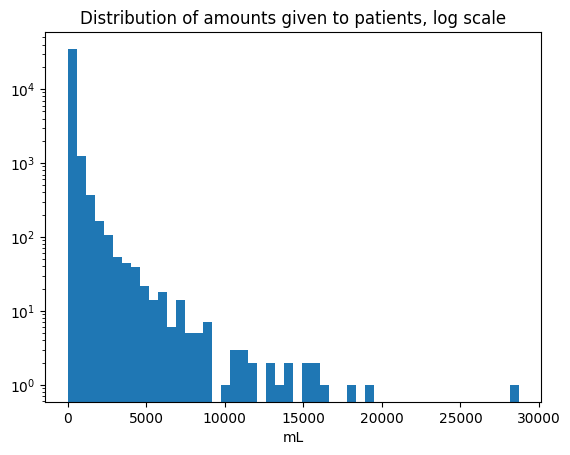

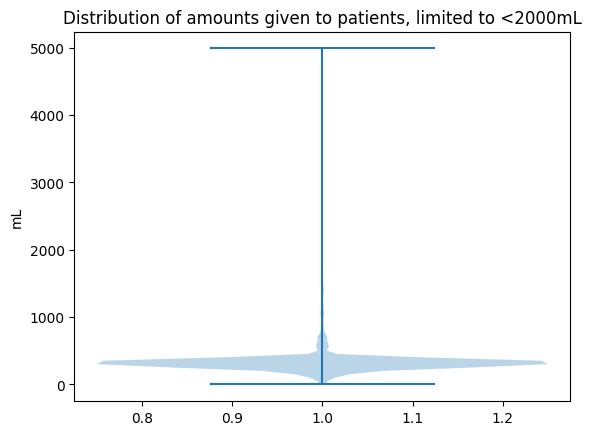

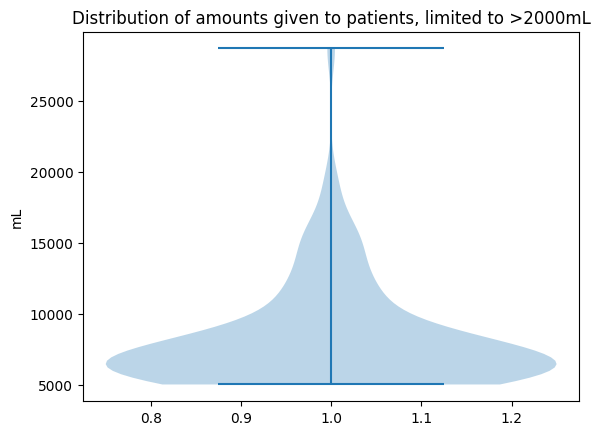

,subject_id,hadm_id,icustay_id,starttime,endtime,itemid,label,amount,amountuom,totalamount,totalamountuom,statusdescription,cancelreason,orderid,linkorderid


In [ ]:
print(completed_results.amountuom.value_counts())
print()
print(completed_results.totalamountuom.value_counts())
print()
print(completed_results.statusdescription.value_counts())
print()
print(completed_results.cancelreason.value_counts())
print()

#what entry has ul?
uLentries = completed_results[completed_results.amountuom == 'uL']
print(uLentries)
print()

print("min amount", min(completed_results.amount), 'max amount', max(completed_results.amount))
print(f"{np.size(completed_results[completed_results.amount < 0])} amounts < 0mL")
print(f"{np.size(completed_results[completed_results.amount > 1000])} amounts > 1000mL")
print(f"{np.size(completed_results[completed_results.amount > 2000])} amounts > 2000mL")
print(f"{np.size(completed_results[completed_results.amount > 10000])} amounts > 10000mL")
print(f"{np.size(completed_results[completed_results.amount > 20000])} amounts > 20000mL")
print(f"{np.size(completed_results[completed_results.amount > 50000])} amounts > 50000mL")
# plt.hist(completed_results.amount, bins=[0, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, max(completed_results.amount)])
# plt.hist(completed_results.amount, bins=[0, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, max(completed_results.amount)], density=True)
plt.hist(completed_results.amount, bins=50, log=True)
plt.title("Distribution of amounts given to patients, log scale")
plt.xlabel("mL")
plt.show()
plt.violinplot(completed_results[completed_results.amount < 5000].amount)
plt.title("Distribution of amounts given to patients, limited to <2000mL")
plt.ylabel("mL")
plt.show()
plt.violinplot(completed_results[completed_results.amount > 5000].amount)
plt.title("Distribution of amounts given to patients, limited to >2000mL")
plt.ylabel("mL")
plt.show()

completed_results[completed_results.amount > 50000]

In [ ]:
with open(f"{query_path}/blood_input_amounts_by_item.sql", 'r') as file:
    amounts_by_item_query = file.read()

amounts_by_item_results = client.query(amounts_by_item_query).to_dataframe()
amounts_by_item_results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,itemid,label,count,avg_ml,min_ml,max_ml
0,225168,Packed Red Blood Cells,24836,328.344719,-735.000000,14250.000000
1,225170,Platelets,4160,246.186608,-116.666662,3010.000200
2,225171,Cryoprecipitate,1073,136.331324,-235.800009,330.000012
3,227070,PACU Packed RBC Intake,75,557.000000,0.000000,2625.000000
4,227071,PACU Platelet Intake,8,390.875000,192.000000,600.000000
5,227072,PACU FFP Intake,14,461.142857,237.000000,1064.000000
6,220970,Fresh Frozen Plasma,8428,363.023850,-325.000020,315276.992800
7,227532,Plasma Pheresis,87,334.098071,4.583334,3743.001180
8,226367,OR FFP Intake,998,1269.651303,0.000000,19509.000000
9,226368,OR Packed RBC Intake,2002,1147.009990,0.000000,28700.000000


In [ ]:
with open(f"{query_path}/completed_blood_input_amounts_by_item.sql", 'r') as file:
    completed_amounts_by_item_query = file.read()

completed_amounts_by_item_results = client.query(completed_amounts_by_item_query).to_dataframe()
completed_amounts_by_item_results

/home/kmorhun/.pyenv/versions/3.12.7/envs/transfusion/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,itemid,label,count,avg_ml,min_ml,max_ml
0,220970,Fresh Frozen Plasma,7163,292.153726,0.136187,13800.000000
1,225168,Packed Red Blood Cells,21358,331.893417,0.200000,14250.000000
2,225170,Platelets,3770,247.730963,2.871000,1441.999980
3,225171,Cryoprecipitate,899,141.294223,4.096000,330.000012
4,226367,OR FFP Intake,947,1295.394931,0.000000,19509.000000
5,226368,OR Packed RBC Intake,1884,1162.985138,0.000000,28700.000000
6,226369,OR Platelet Intake,741,492.190283,0.000000,4627.000000
7,226371,OR Cryoprecipitate Intake,191,369.340314,92.000000,7000.000000
8,227070,PACU Packed RBC Intake,71,573.422535,250.000000,2625.000000
9,227071,PACU Platelet Intake,6,388.666667,192.000000,594.000000


In [ ]:
# # curiosity, use the rbc_transfusion.sql file from github ==> doesn't work :/
# with open(f"{query_path}/rbc_transfusion.sql", 'r') as file:
#     rbc_transfusion_query = file.read()

# rbc_transfusion_results = client.query(rbc_transfusion_query).to_dataframe()
# rbc_transfusion_results